In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, TensorDataset
#from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device}")

Using cpu


In [202]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])
data = data[data['year'] < 2021]

In [203]:
def split_data(data: pd.DataFrame, train_size=0.9, val_size=0.05):
    '''
    Split the time series data into train, validation, and test sets
    for each country individually.
    '''

    train_data = []
    val_data = []
    test_data = []

    countries = data['iso3'].unique()
    
    for country in countries:
        data_trg = data[data['iso3'] == country]
        
        n = len(data_trg)
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        
        train_data.append(data_trg.iloc[:train_end])
        val_data.append(data_trg.iloc[train_end:val_end])
        test_data.append(data_trg.iloc[val_end:])
        
    # Concatenate all countries' data back into single DataFrames
    train_data = pd.concat(train_data)
    val_data = pd.concat(val_data)
    test_data = pd.concat(test_data)

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(data)

In [204]:



def sequencing(data: pd.DataFrame, sequence_length: int): 
 
    sequences =  []
    targets = []


    # Create sequences for each country

    countries = data['iso3'].unique()
    for country in countries:
        data_trg = data[data['iso3'] == country]
        n = len(data_trg)
        data_ftr = data_trg.drop(["net_migration_tp1", "iso3", "set"], axis = 1)
        
        # Iterate from the end of the DataFrame to the beginning to create sequences
        for i in range(n - sequence_length + 1):
            # Extract the sequence of features and the target value
            seq = data_ftr.iloc[i:i + sequence_length].values
            target = data_trg.iloc[(i + sequence_length)-1]['net_migration_tp1']
            
            sequences.append(seq)
            targets.append(target)

    sequences = torch.tensor(sequences, dtype = torch.float32)
    targets = torch.tensor(targets, dtype = torch.float32)

    return sequences, targets

x_train,y_train  = sequencing(train_data, 3)
x_val,y_val  = sequencing(val_data, 3)
x_test,y_test  = sequencing(test_data, 3)

train_set = TensorDataset(x_train,y_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

val_set = TensorDataset(x_val,y_val)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

test_set = TensorDataset(x_test,y_test)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)



'''

x_train,y_train  = sequencing(data, 3)
train_set = TensorDataset(x_train,y_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

'''

In [205]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [206]:
input_size = len(x_train[0][0])  # Number of features per time step; just use the first sequence to check...
hidden_size = 256
num_layers = 2
output_size = 1  # Predicting a single value (migration flow) for the next year

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

In [207]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [208]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

In [209]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            

stopper = EarlyStopping()

In [210]:
def validate(model: LSTMModel, val_loader: DataLoader, criterion: nn.HuberLoss) -> float:
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for features, targets in val_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1)  
            loss = criterion(pred, targets)
            total_loss += loss.item()
    
    return total_loss

def train(model: LSTMModel, train_loader: DataLoader, val_loader: DataLoader, epochs: int, criterion: nn.HuberLoss) -> list:

    losses = []

    for epoch in range(epochs):

        # Train step

        model.train()

        epoch_train_loss = 0

        for features, targets in train_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1) 
            loss = criterion(pred, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation step

        epoch_val_loss = validate(model, val_loader, criterion)

        stopper(epoch_val_loss)

        print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
        losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})
        
        if stopper.counter == 0:
            checkpoint(model)
        
        if stopper.early_stop:
            print(f"Patience exceeded, stopping training & restoring best weights...")
            restore_best_weights(model)
            break
        


    return losses

In [211]:
losses = train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=100, criterion=criterion)

Epoch 1 done: Training loss: 0.4788, Validation loss: 0.0346, Patience counter: 0
Epoch 2 done: Training loss: 0.1831, Validation loss: 0.0397, Patience counter: 1
Epoch 3 done: Training loss: 0.1822, Validation loss: 0.0346, Patience counter: 2
Epoch 4 done: Training loss: 0.1826, Validation loss: 0.0349, Patience counter: 3
Epoch 5 done: Training loss: 0.1802, Validation loss: 0.0348, Patience counter: 4
Epoch 6 done: Training loss: 0.1799, Validation loss: 0.0346, Patience counter: 5
Epoch 7 done: Training loss: 0.1827, Validation loss: 0.0351, Patience counter: 6
Epoch 8 done: Training loss: 0.1783, Validation loss: 0.0346, Patience counter: 7
Epoch 9 done: Training loss: 0.1780, Validation loss: 0.0346, Patience counter: 8
Epoch 10 done: Training loss: 0.1794, Validation loss: 0.0372, Patience counter: 9
Epoch 11 done: Training loss: 0.1795, Validation loss: 0.0387, Patience counter: 10
Patience exceeded, stopping training & restoring best weights...


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_20304\3484606476.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth"))


<Axes: xlabel='epoch', ylabel='value'>

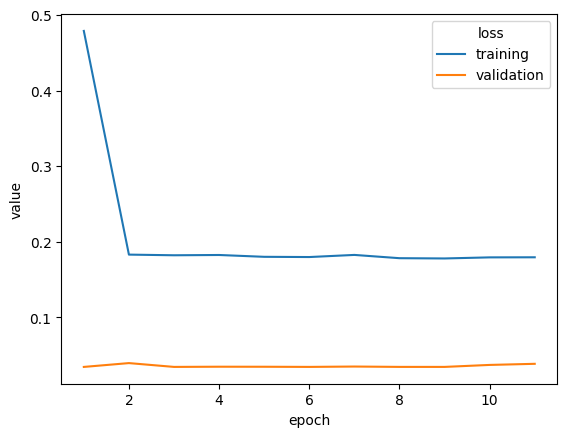

In [212]:
losses = pd.DataFrame(losses)

sns.lineplot(
    data=losses.melt(id_vars="epoch", var_name="loss"),
    x="epoch",
    y="value",
    hue="loss"
)

In [213]:
def eval(model: LSTMModel, test_loader: DataLoader):
    model.eval()
    
    mse = []
    mae = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            targets = targets.unsqueeze(1)
            
            mse_i = F.mse_loss(outputs, targets, reduction='mean').item()
            mse.append(mse_i)

            mae_i = F.l1_loss(outputs, targets, reduction='mean').item()
            mae.append(mae_i)
    
    metrics = {
        "MSE": np.mean(mse),
        "RMSE": np.sqrt(np.mean(mse)),
        "MAE": np.mean(mae)
    }
    
    return metrics
metrics = eval(model, test_loader)
metrics

{'MSE': 0.0014123181729647674,
 'RMSE': 0.03758082187718581,
 'MAE': 0.013572435059091625}

In [214]:
# Manually selected from dataset

omin = -2290411 # PAK 2016
omax = 1866819 # USA 1997



scale = omax - omin

print(f"Metrics rescaled to original units:\n\nMSE: {metrics['MSE'] * (scale ** 2)}\nRMSE: {metrics['RMSE'] * scale}\nMAE: {metrics['MAE'] * scale}")

Metrics rescaled to original units:

MSE: 24408475361.093773
RMSE: 156232.12013249318
MAE: 56423.73420070748


In [215]:
def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

# Rescaling back to original units (migrants):

def rescale(scaled: list, omin: float, omax: float) -> np.array:
    return [x * (omax - omin) + omin for x in scaled]

In [216]:
predictions, actuals = collect_predictions(model, test_loader)
predictions, actuals = rescale(predictions, omin=omin, omax=omax), rescale(actuals, omin=omin, omax=omax)

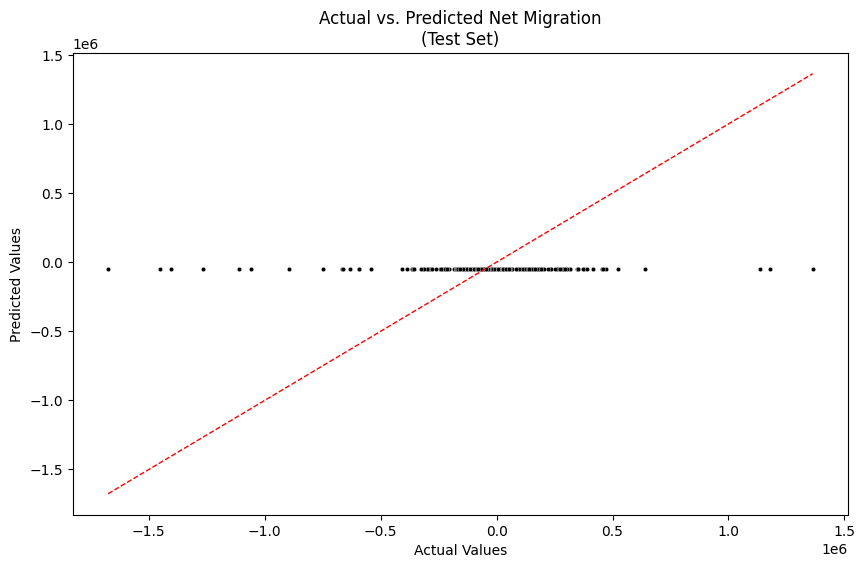

In [217]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)
# Main diagonal:
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration\n(Test Set)')
plt.show()

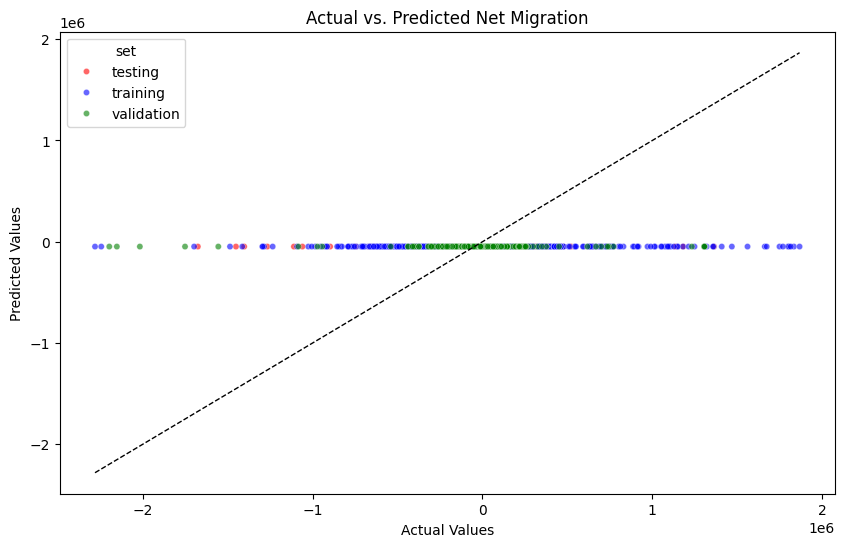

In [218]:
train_pred, train_act = collect_predictions(model, train_loader)
val_pred, val_act = collect_predictions(model, val_loader)

train_pred, train_act = rescale(train_pred, omin, omax), rescale(train_act, omin, omax)
val_pred, val_act = rescale(val_pred, omin, omax), rescale(val_act, omin, omax)

all_predictions = pd.concat([
    pd.DataFrame({"predicted": train_pred, "actual": train_act, "set": "training"}),
    pd.DataFrame({"predicted": val_pred, "actual": val_act, "set": "validation"}),
    pd.DataFrame({"predicted": predictions, "actual": actuals, "set": "testing"})
])

all_predictions['set'] = pd.Categorical(all_predictions['set'], categories=['testing', 'training', 'validation'])
all_predictions = all_predictions.sort_values('set').reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_predictions, 
    x="actual",
    y="predicted",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.6
)
# Main diagonal:
min_val = min(min(all_predictions["actual"]), min(all_predictions["predicted"]))
max_val = max(max(all_predictions["actual"]), max(all_predictions["predicted"]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration')
plt.show()